# XGBoost model
eXtreme Gradient Boosting ([XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md)) is an implementation of gradient boosted decision trees designed for speed and performance.
This notebook implements the final model of XGBoost used in our analysis.
Since it was not easy to integrate our custom evaluation function (BIP_error), we tried to minimize many built-in evaluation metrics of the XGBoost library (mae, rmse..), and then used the one that produced the best results in term of BIP_error, which in this case was rmse.

#### Feature selection
The feature selection was performed both by using the feature_selection library of SciKitLearn and by increasingly excluding the least important features that were detected by the model and plot after the training of the model

#### Hyperparameters Tuning
The tuning of the Hyperparameters for XGBoost was done using the RandomizedSearchCV method and using SciKitLearn wrapper of XGBoost (XGBRegressor) with a 5-fold cross-validation on 30% of the train test and providing it the parameters: gamma, learning_rate, max_depth, reg_alpha onto which apply the Grid Search. The best parameters it found were: {'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}, however, testing the parameters with our train-test split policy did not produce better results than the parameters found by manually try some combinations, thus, in the end we modified them.

#### Train-test split
Initially we split train and test sets with the train_test_split in model_selection of SciKitLearn, the results were too optimistic and then we decided to split in a way that would result in having a test set similar to the one we were going to be evaluated on, so we selected some test sets a pair of months in the 24 months of the train, in particular we concentrated on the pairs that seemed more significant in our analysis based on the real test we would have had to predict in the end which are:
* January and February 2018
* March and April 2017
* March and April 2016

The first one because it is the last 2 months we have and in a way this captures the real test set we have to predict, the other two were chosen because the real test set is for March and April.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline

from RMSE import rmspe,rmspe_xg
import modify_dataset as md

In [2]:
#Common error function to minimize: Root Mean Square Percentage Error
#
#def ToWeight(y):
#    w = np.zeros(y.shape, dtype=float)
#    ind = y != 0
#    w[ind] = 1./(y[ind]**2)
#    return w
#
#
#def rmspe(yhat, y):
#    w = ToWeight(y)
#    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
#    return rmspe
#
#
#def rmspe_xg(yhat, y):
#    # y = y.values
#    y = y.get_label()
#    y = np.exp(y) - 1
#    yhat = np.exp(yhat) - 1
#    w = ToWeight(y)
#    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
#    return "rmspe", rmspe
#

In [3]:
df = pd.read_csv("dataset/preprocessed_train_PCA.csv")

In [4]:
df = df.drop(['NumberOfCustomers'], axis=1)
#OHE attr.
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)
#only for pca dataset
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.shape

(433958, 44)

In [6]:
train = md.get_fake_train4(df)

In [7]:
train.shape

(397455, 44)

In [8]:
test = md.get_fake_test4(df)
test.shape

(36503, 44)

### Selecting predictive features 

In [9]:
from pprint import pprint
features = list(train.columns.values)
features.remove('NumberOfSales')
features.remove('StoreID')
features.remove('D_DayOfweek')
features.remove('Date')
features.remove('MeanRegionCustomers')

features.remove('p11')
features.remove('p12')
features.remove('p7')
features.remove('p9')
#4.5%

features.remove('p8')
features.remove('p10')
#4.2%
print("features:")

pprint(features)

features:
['IsHoliday',
 'HasPromotions',
 'NearestCompetitor',
 'Region',
 'Region_AreaKM2',
 'Region_GDP',
 'Region_PopulationK',
 'CloudCover',
 'Max_VisibilityKm',
 'Min_VisibilitykM',
 'WindDirDegrees',
 'D_Day',
 'D_DayOfYear',
 'D_Month',
 'D_Year',
 'StoreType_SuperMarket',
 'StoreType_HyperMarket',
 'StoreType_StandardMarket',
 'StoreType_ShoppingCenter',
 'AssortmentType_General',
 'AssortmentType_WithNFDept',
 'AssortmentType_WithFishDept',
 'MeanStoreSales',
 'MeanRegionSales',
 'MeanCustomers',
 'D_DayOfWeek_cos',
 'D_DayOfWeek_sin',
 'p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6']


In [10]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


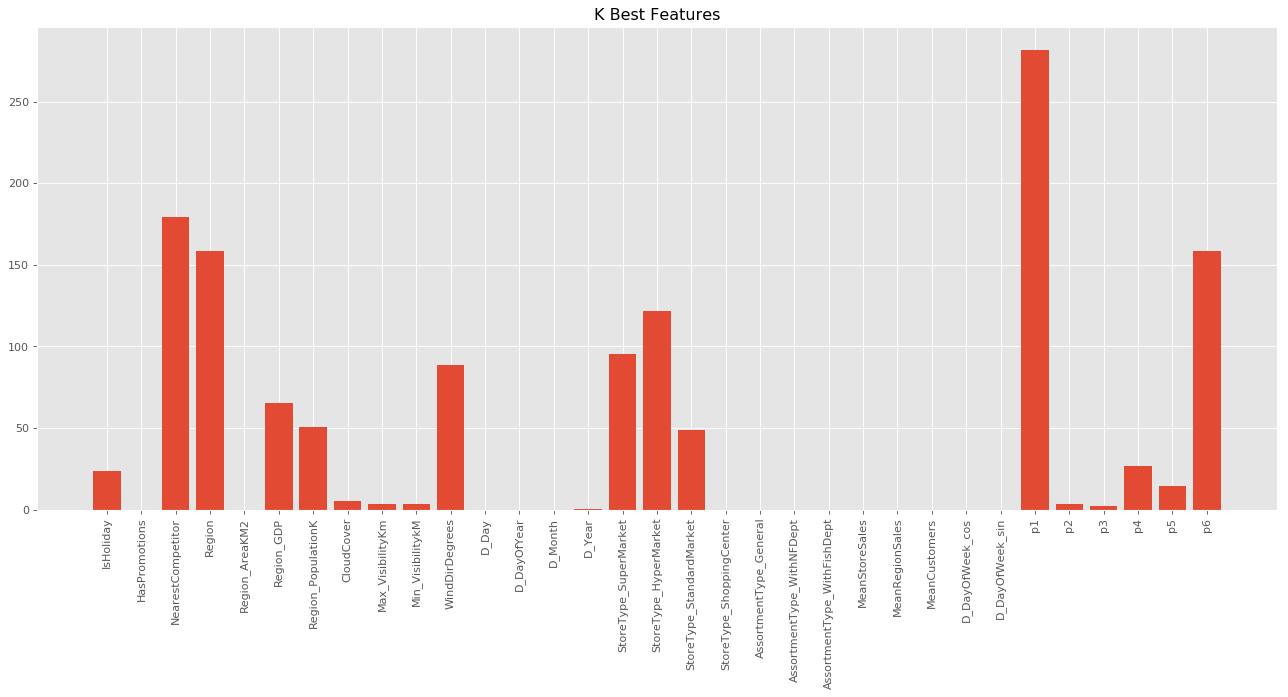

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# Perform feature selection
selector = SelectKBest(f_regression, k=20)
selector.fit(train[features], train['NumberOfSales'])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores for each feature 
plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.title('K Best Features')
plt.show()

In [12]:
#split in train and test (not real test which is called test and is the fake test provided by md)
#X_train, X_test = train_test_split(train, test_size=0.05)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [13]:
#from xgboost.sklearn import XGBRegressor # wrapper
## XGB with sklearn wrapper
## the same parameters as for xgboost model
#params_sk = {'max_depth': 8, 
#            'n_estimators': 100, # the same as num_rounds in xgboost
#            'objective': 'reg:linear', 
#            'subsample': 1.0, 
#            'colsample_bytree': 0.3, 
#            'learning_rate': 0.1, 
#            'seed': 23}     
#
#skrg = XGBRegressor(**params_sk)
#
#skrg.fit(X_train[features], np.log(X_train["NumberOfSales"] + 1))

In [14]:
#import scipy.stats as st
#
#params_grid = {  
#    'learning_rate': st.uniform(0.001, 0.2),
#    'max_depth': list(range(6, 20, 2)),
#    'gamma': st.uniform(0, 40),
#    'reg_alpha': st.expon(0, 40)}
#
#search_sk = RandomizedSearchCV(skrg, params_grid, cv = 3, verbose=2) # 3 fold cross validation
#search_sk.fit(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#
## best parameters
#print(search_sk.best_params_); print(search_sk.best_score_)

### Hyperparameters tuning
The result was obtained using 0.3 of the train set (22 months) at random.
#### Result
{'gamma': 14.557397447034148, 'learning_rate': 0.17070528151248315, 'max_depth': 16, 'reg_alpha': 11.010959407512171}
0.8171277539145538

In [15]:
dtrain = xgb.DMatrix(train[features], np.log(train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(test[features], np.log(test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [16]:
#Using tuned params
params = {"objective": "reg:linear",
          "eta": 0.2,   #0.17
          "max_depth": 8,
          "subsample": 0.8,  #0.8
          "colsample_bytree": 0.3, #0.3 #0.2
          "silent": 1,
          "nthread":-1,
          #added as a test
          "eval_metric": "rmse",
          "gamma": 0.5, #2
          #"seed": 23,
          #"reg_alpha": 2  #4
          #"gamma": 14.5573974470,  #added as a test
          "reg_alpha": 1
          }

#reg_alpha 
#reg_lambda
num_trees = 200 #400

In [17]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, verbose_eval=True)

[0]	test-rmse:6.29091	train-rmse:6.33634
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 20 rounds.
[1]	test-rmse:5.02845	train-rmse:5.07358
[2]	test-rmse:4.01427	train-rmse:4.06365
[3]	test-rmse:3.21356	train-rmse:3.25697
[4]	test-rmse:2.56815	train-rmse:2.60861
[5]	test-rmse:2.05195	train-rmse:2.09155
[6]	test-rmse:1.64065	train-rmse:1.678
[7]	test-rmse:1.31437	train-rmse:1.34836
[8]	test-rmse:1.04977	train-rmse:1.0878
[9]	test-rmse:0.843848	train-rmse:0.87975
[10]	test-rmse:0.680612	train-rmse:0.716596
[11]	test-rmse:0.557552	train-rmse:0.586062
[12]	test-rmse:0.458861	train-rmse:0.484858
[13]	test-rmse:0.382966	train-rmse:0.402906
[14]	test-rmse:0.330598	train-rmse:0.341046
[15]	test-rmse:0.293261	train-rmse:0.296605
[16]	test-rmse:0.26856	train-rmse:0.262856
[17]	test-rmse:0.252527	train-rmse:0.236747
[18]	test-rmse:0.238165	train-rmse:0.216381
[19]	test-rmse:0.227473	train-rmse:0.200319
[20]	tes

### Plotting Trees

In [18]:
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (15, 6)
#plt.rcParams['figure.figsize'] = [40.0,20.0]
#plt.rcParams['figure.dpi']=400
#plt.rcParams.update({'font.size': 30})

In [19]:
from xgboost import plot_tree
#plot_tree(gbm)


In [20]:
#xgb.to_graphviz(gbm, num_trees=0, rankdir='LR', **{'size':str(10)})

In [21]:
#xgb.to_graphviz(gbm, num_trees=1, rankdir='LR', **{'size':str(10)})

### Validating

In [22]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, test['NumberOfSales'].values)
print('error', error)

Validating
error 0.1648443658895011


RMSE

## Feature importance analysis:

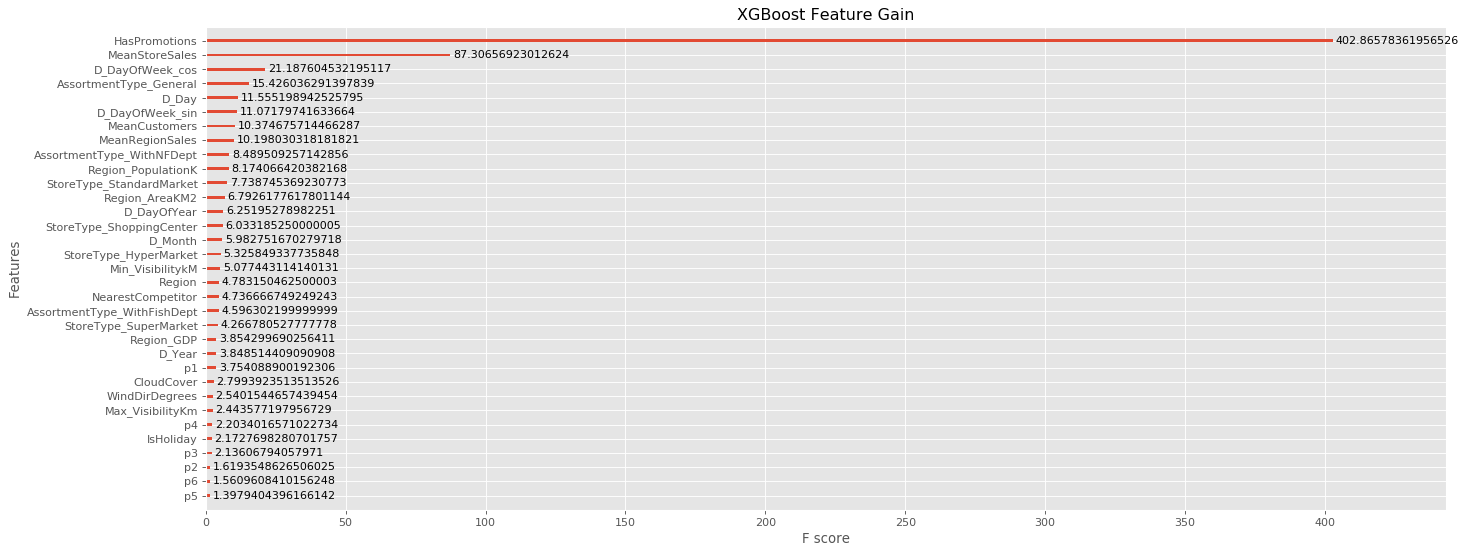

In [23]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

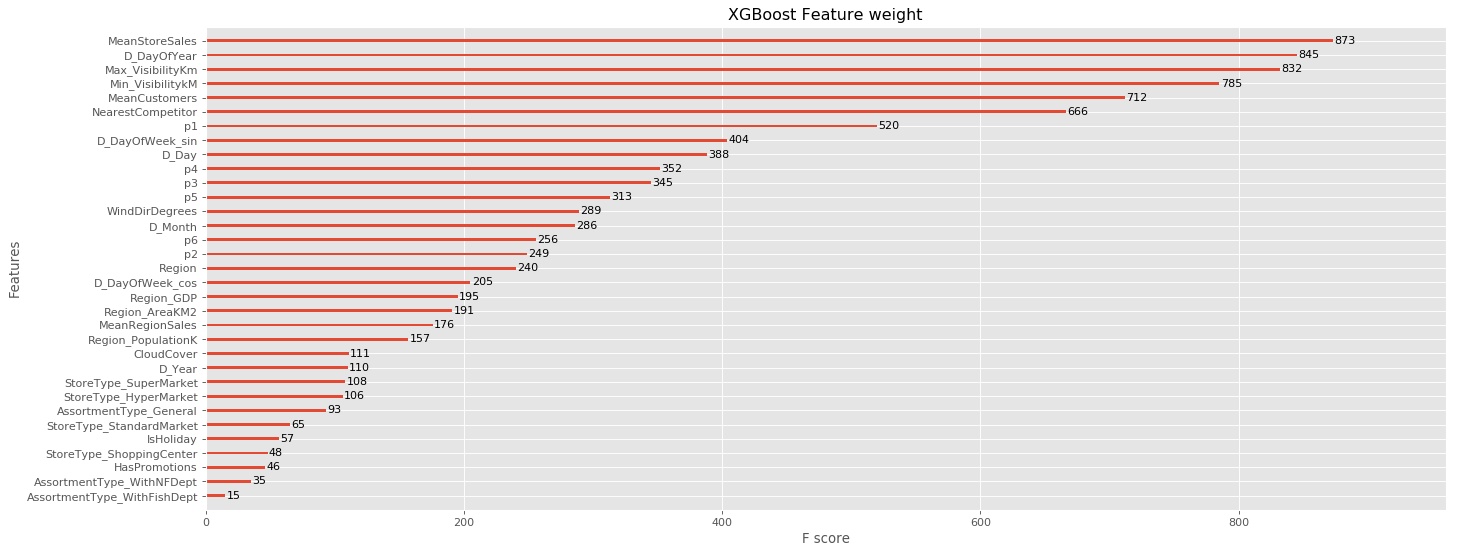

In [24]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

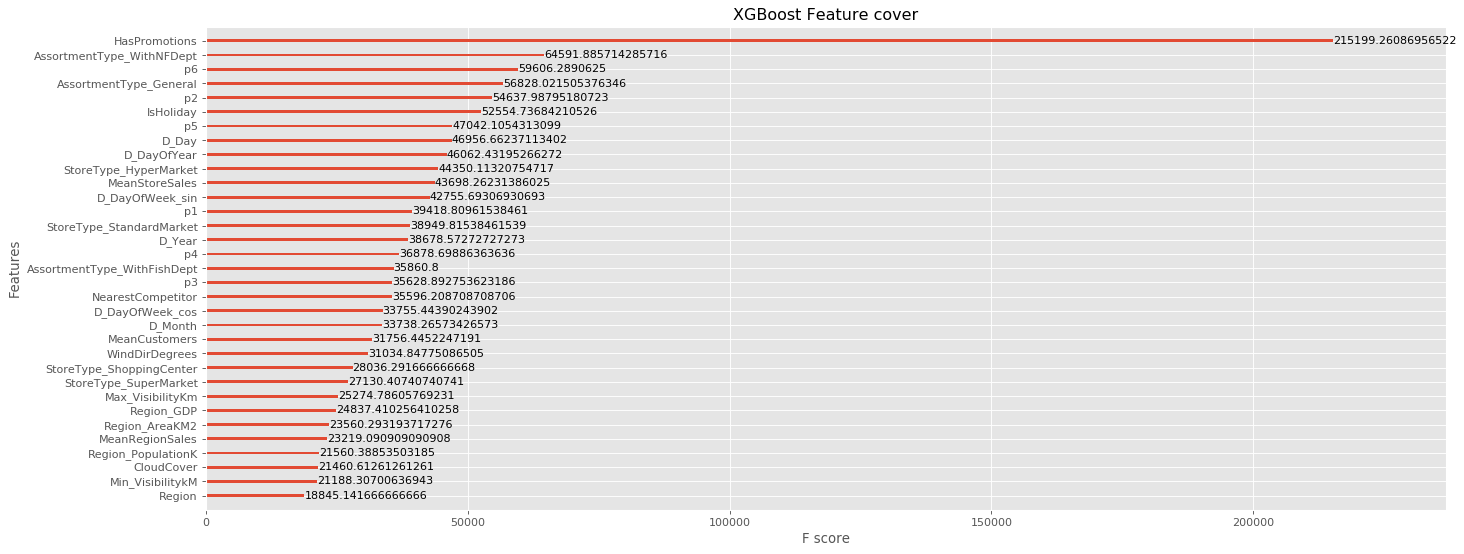

In [25]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [26]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [27]:
test['_NumberOfSales'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

C:\Users\Mirko\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## BIP Error

on test | BIP | on train
0.16 0.0448 0.9
0.168 0.0454 0.10
0.158 0.046 0.13
0.165 0.052 0.15
0.16 0.49 0.14
0.16 0.0445 0.10
0.155 0.046 0.127

In [43]:
from BIP import get_BIP_error
error1 = get_BIP_error(test)

Number of regions identified: 11
BIP total error: 0.03288920501607791


In [46]:
test.to_csv('./dataset/test4_64_Model_XGBoost_final.csv', index=False)

In [29]:
diff=test['NumberOfSales']-test['_NumberOfSales']

In [30]:
diff.head(15).T

253    3317.606445
254   -1681.518066
255     210.546387
256      60.530273
257    1132.324219
258    2673.647461
259     717.887695
260     619.229980
261      48.647949
262     287.054199
263     249.715332
264    -441.169922
265    -493.680664
266     121.742676
267     246.571289
dtype: float32

In [31]:
diff.mean()

-19.987455368041992

In [32]:
train_probs.shape

(36503,)

In [33]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [34]:
compare = test[['NumberOfSales','_NumberOfSales']]

### Saving TEST

In [35]:
#test.to_csv('./dataset/XGB5_fake_test.csv', index=False)

In [36]:
error = rmspe(test['_NumberOfSales'].values, test['NumberOfSales'].values)
print('error', error)

error 0.1648443658895011


In [37]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
11955,3610,5416.145996
11956,3734,4650.918457
11957,4178,4823.638672
11958,4723,4899.433105
11959,5969,5240.562500
11960,7948,6735.676270
11961,8569,8175.557617
11962,6798,6293.057129
11963,5900,5941.414551
11964,5292,5728.831543


In [38]:
compare[1000:1100]

,NumberOfSales,_NumberOfSales
11955,3610,5416.145996
11956,3734,4650.918457
11957,4178,4823.638672
11958,4723,4899.433105
11959,5969,5240.562500
11960,7948,6735.676270
11961,8569,8175.557617
11962,6798,6293.057129
11963,5900,5941.414551
11964,5292,5728.831543


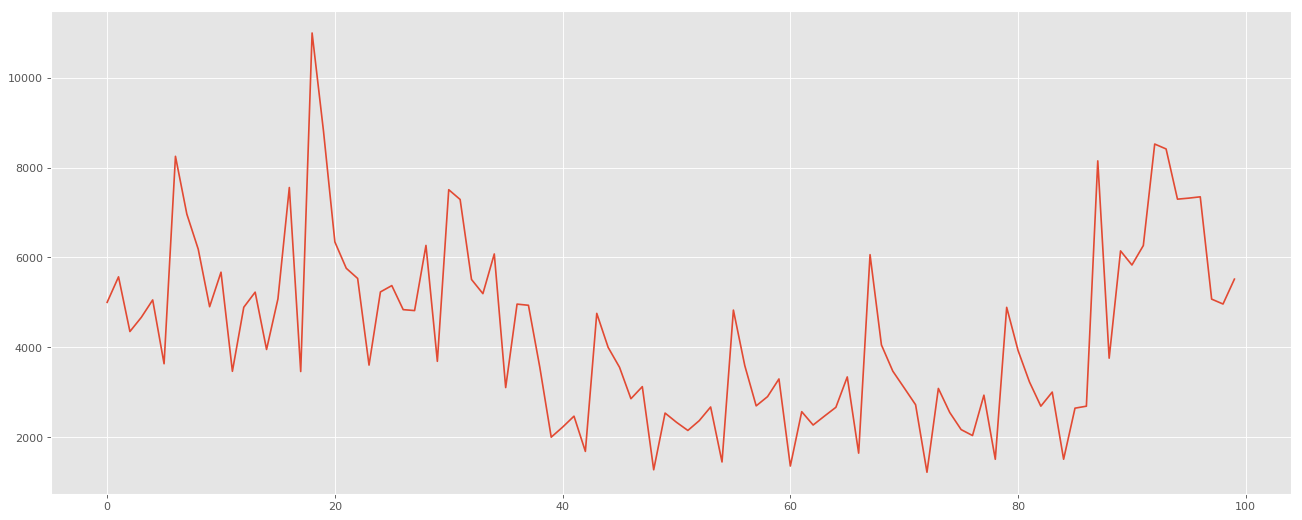

In [39]:
#REAL
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

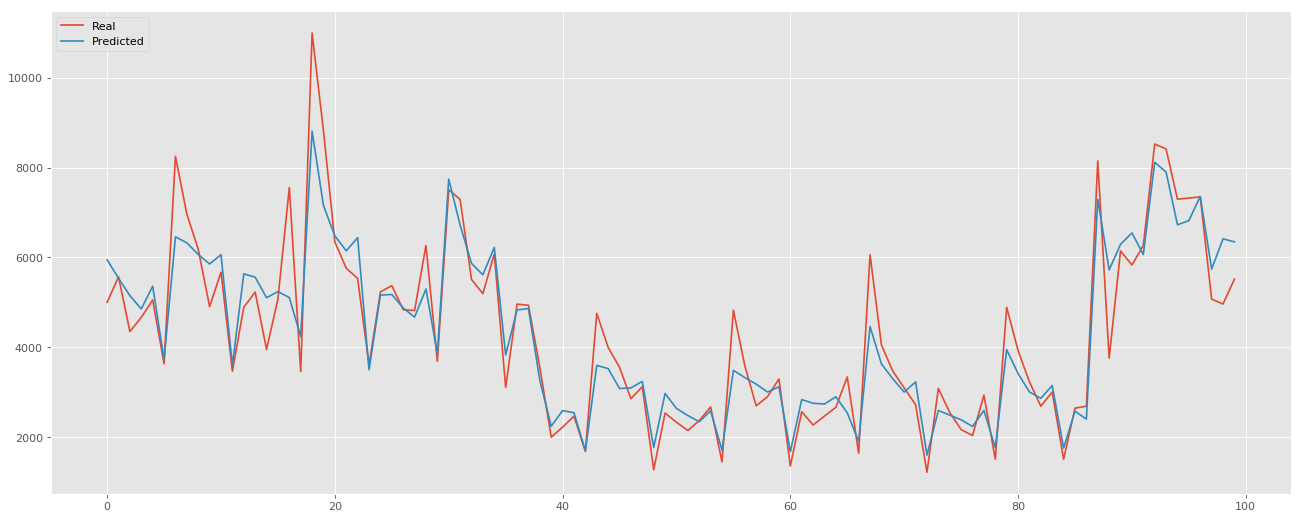

In [40]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Real', 'Predicted'], loc='upper left')
plt.show()

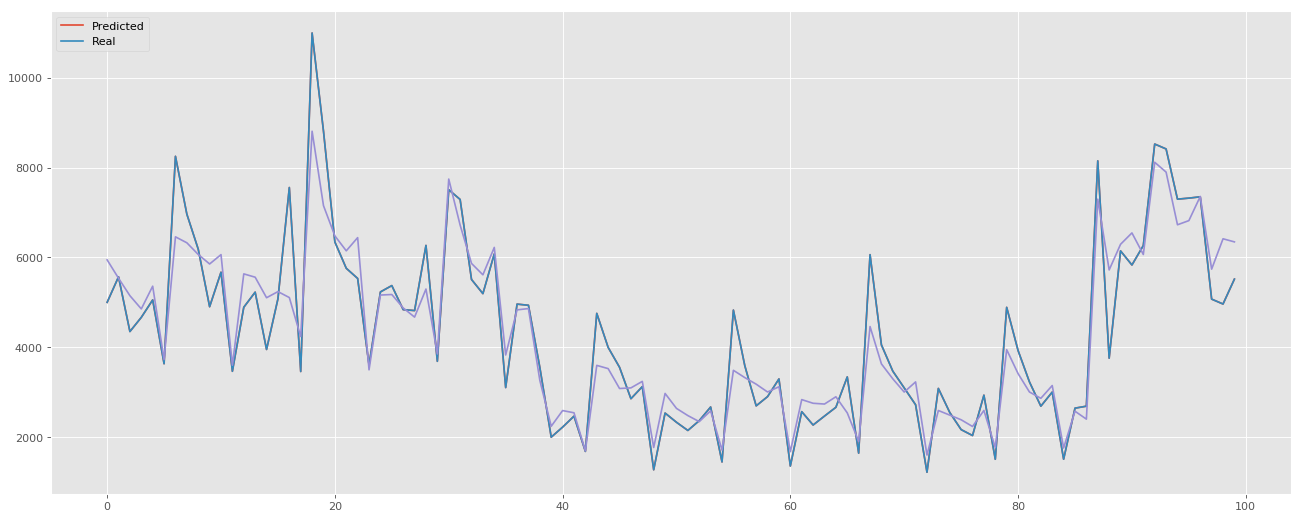

In [41]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [42]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

NameError: name 'X_test' is not defined

In [ ]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

In [ ]:
Y = df.iloc[:, 3]

In [ ]:
Y